# PCA & LDA on MNIST

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

## 1. Train KNN on MNIST Dataset

In [2]:
train_data = datasets.MNIST(root = './data/02/',
                            train=True,
                            download=True,
                            transform=transforms.ToTensor())
test_data = datasets.MNIST(root = './data/02/',
                            train=False,
                            download=True,
                            transform=transforms.ToTensor())
print('number of training data : ', len(train_data))
print('number of test data : ', len(test_data))

number of training data :  60000
number of test data :  10000


In [3]:
# 데이터 모양 확인을 위해 dataframe 형태로 변환

feat_cols = ['pixel'+str(i) for i in range(784)]
df_train = pd.DataFrame(train_data.data.reshape(60000,-1).numpy(), columns = feat_cols)
df_test = pd.DataFrame(test_data.data.reshape(10000,-1).numpy(), columns = feat_cols)

df_train.shape, df_test.shape

((60000, 784), (10000, 784))

In [4]:
df_train.head(3)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<Figure size 640x480 with 0 Axes>

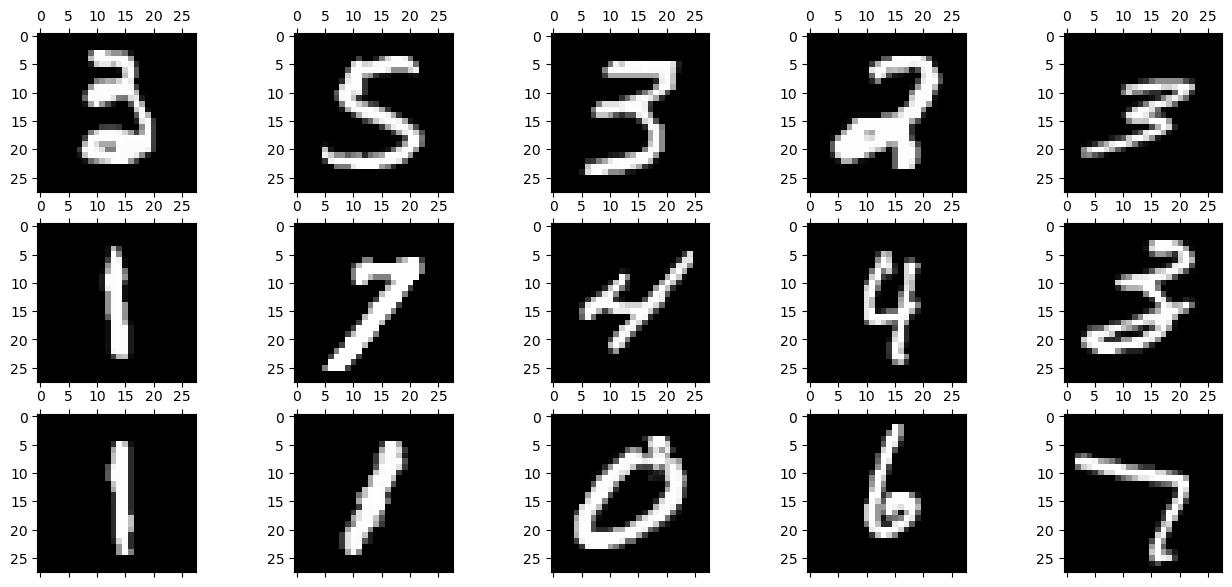

In [5]:
# 데이터 형태 시각화

import matplotlib.pyplot as plt

rndperm = np.random.permutation(df_train.shape[0]) # df_train.shape[0] (=정수) 의 범위 내에서 무작위로 셔플한 것과 동일함

# Plot the graph
plt.gray()
fig = plt.figure( figsize=(16,7) )
for i in range(0,15):
    ax = fig.add_subplot(3,5,i+1)
    ax.matshow(df_train.loc[rndperm[i], feat_cols].values.reshape((28,28)).astype(float))
plt.show()

In [6]:
# 학습 데이터 준비

import numpy as np

X_train = train_data.data.reshape(60000,-1).numpy()
y_train = train_data.targets.numpy()

X_test = test_data.data.reshape(10000,-1).numpy()
y_test = test_data.targets.numpy()

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 784), (60000,), (10000, 784), (10000,))

- 표준화

In [7]:
# 표준화
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [8]:
# KNN 학습 - Baseline

from sklearn.neighbors import KNeighborsClassifier
import time

start_time = time.time()
clf = KNeighborsClassifier(n_neighbors= 5)
clf.fit(X_train, y_train)
print('Fit time : ', time.time() - start_time)

Fit time :  0.12328171730041504


In [9]:
from sklearn.metrics import accuracy_score

start_time = time.time()
pred = clf.predict(X_test)
print('Fit time : ', time.time() - start_time)
print(accuracy_score(y_test, pred))

Fit time :  38.320809841156006
0.9443


## 2. PCA & LDA 적용하기

In [10]:
# PCA - 누적 기여율 
from sklearn.decomposition import PCA

pca = PCA()
X_train_pca = pca.fit_transform(X_train)
cum_explained_var_ratio= np.cumsum(pca.explained_variance_ratio_)

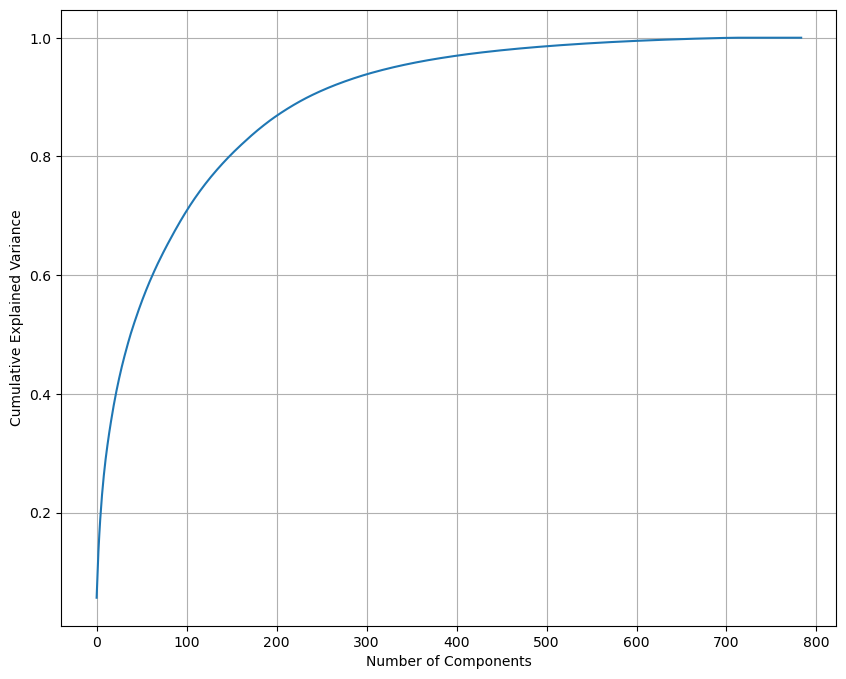

In [38]:
# 누적 기여율 그래프
plt.figure(figsize=(10, 8))
plt.plot(cum_explained_var_ratio, linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)

plt.show()

In [12]:
pca_result = pd.DataFrame({'explained_variance' : pca.explained_variance_, 
                           'explained_variance_ratio' : pca.explained_variance_ratio_,},
                         index = np.array([f"pixel{num+1}" for num in range(X_train.shape[1])]))
pca_result['cumulative_explained_variance_ratio'] = pca_result['explained_variance_ratio'].cumsum()

print(pca_result[pca_result['cumulative_explained_variance_ratio'] >= 0.8].index[0])
pca_result.head()

pixel149


,explained_variance,explained_variance_ratio,cumulative_explained_variance_ratio
pixel1,40.487635,0.056467,0.056467
pixel2,29.241698,0.040783,0.097250
pixel3,26.811804,0.037394,0.134644
pixel4,20.686618,0.028851,0.163495
pixel5,18.076650,0.025211,0.188706


In [13]:
# PCA 적용
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

pca = PCA(n_components = 149)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

clf_pca = KNeighborsClassifier(n_neighbors= 5)
clf_pca.fit(X_train_pca, y_train)

KNeighborsClassifier()

In [14]:
# LDA - 누적 기여율
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
X_train_lda = lda.fit_transform(X_train, y_train)

In [15]:
X_train_lda.shape

(60000, 9)

In [16]:
lda.explained_variance_ratio_

array([0.2392286 , 0.20180995, 0.17849695, 0.10652571, 0.09406712,
       0.06906025, 0.04973746, 0.03429077, 0.0267832 ])

In [17]:
# 누적 기여율
lda_result = pd.DataFrame({'explained_variance_ratio' : lda.explained_variance_ratio_,},
                         index = np.array([f"pixel{num+1}" for num in range(X_train_lda.shape[1])]))
lda_result['cumulative_explained_variance_ratio'] = lda_result['explained_variance_ratio'].cumsum()

print(lda_result[lda_result['cumulative_explained_variance_ratio'] >= 0.8].index[0])
lda_result

pixel5


,explained_variance_ratio,cumulative_explained_variance_ratio
pixel1,0.239229,0.239229
pixel2,0.201810,0.441039
pixel3,0.178497,0.619535
pixel4,0.106526,0.726061
pixel5,0.094067,0.820128
pixel6,0.069060,0.889189
pixel7,0.049737,0.938926
pixel8,0.034291,0.973217
pixel9,0.026783,1.000000


In [18]:
lda = LinearDiscriminantAnalysis(n_components=5)
X_train_lda = lda.fit_transform(X_train, y_train)

KNeighborsClassifier()

## 3. 결과 비교하기

In [19]:
# PCA 결과
start_time = time.time()
pred = clf_pca.predict(X_test_pca)
print('Fit time : ', time.time() - start_time)
print('accuracy_score:',accuracy_score(y_test, pred))

Fit time :  24.675546884536743
accuracy_score: 0.9559


In [20]:
# LDA 결과
start_time = time.time()
y_pred = lda.predict(X_test)
print('Fit time : ', time.time() - start_time)
print(accuracy_score(y_test, y_pred))

Fit time :  0.07088899612426758
0.873


## 4. PCA & LDA 장단점 정리하기

#### 장단점을 자유롭게 적어주세요!

- PCA
  - 장점: 
      - 데이터 간 분산이 큰 경우 좋은 성능을 보인다. 분산을 최대화하는 방향으로 주성분을 찾아내기 때문에 데이터의 손실을 최소화하고 계산 효율성을 높인다.
      - 비지도 학습 방법으로, 정답 레이블 정보가 필요하지 않다.      
  - 단점: 
      - 변환된 각각의 주성분을 직관적으로 해석하기 어렵다
      - 선형 변환을 기반으로 하기 때문에 변수들이 비선형 관계를 가질 때 적용하기 어렵다

- LDA
  - 장점: 
      - 클래스 간의 분산을 크게, 클래스 내의 분산을 작게하여 분류 작업에서 유용하다.
      - 설명변수간의 공분산 구조를 반영하며, 이 가정이 위반되더라도 비교적 robust하다. 
  - 단점: 
      - 가우시안 분포를 가정하므로 데이터가 정규분포를 따라야 한다. 만약 정규분포 가정에 위배될 경우, 설명력이 떨어진다. 
      - 지도 학습이기 때문에 정답 레이블이 존재해야 한다